https://colab.research.google.com/drive/1RaoP18h1BdiDwqn5w_niOBwXzJSaZ1mP#scrollTo=76ea5658

## Libraries Load

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
# 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor
# KFold(CV), partial - for using optuna
from sklearn.model_selection import KFold
from functools import partial
# hyper-parameter tuning
import optuna

## Data Load

In [20]:
base_path = '~/Desktop/ETC/dataset/mercedes-benz-greener-manufacturing/'
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

# Template
- 1. EDA
- 2. 전처리
- 3. 데이터 분할
- 4. 학습
- 5. hyper-parameter tuning
- 6. 최종 테스트 

In [21]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [22]:
train.iloc[:,:]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


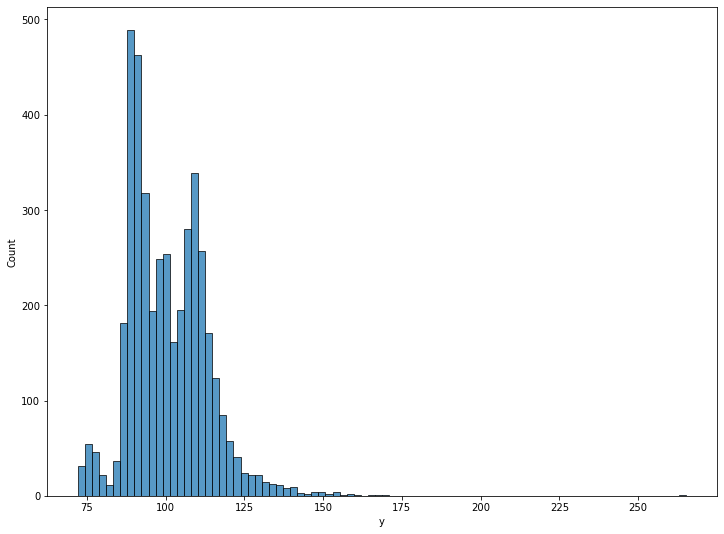

In [23]:
plt.figure(figsize=(12,9))
sns.histplot(data=train,x='y')
plt.show()

In [24]:
train[train.y > 170] # outlier 발견

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,...,0,0,0,0,0,0,0,0,0,0


# EDA
#### 특징


1. 결측치 : 없음


2. dtype이 object인 column : X0 ~ X8까지 8개. (categorical feature)

> -> 어떻게 처리할지 고민해야함. (Ordinal Encoding VS One-Hot Encoding)

> -> categorical feature들은 종류 정보들이 알파벳으로 되어있으며(anomynized) 이 정보들 대비 target값의 차이가 있는지 확인.
(특별하게 관련 없음)

> -> binary feature들중에서 0만 가지고 있는 column들이 있음.

> -> 정보가 충분하지 않다고 판단(target value와의 관련성 0) 삭제.


3. target distribution
-> train data에 180을 넘는 데이터가 하나 있음. 이 데이터를 outlier라고 생각하고 제거.

# 전처리
 - 결측치 처리
 - 다중공선성 처리
 - Encoding Categorical Features
 - feature extraction

In [25]:
train[train.isnull().any(axis=1)]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [26]:
test[test.isnull().any(axis=1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [27]:
categorical_features = train.columns[2:10] # categorical_feature
categorical_features

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [28]:
card1 = train.columns[train.nunique() == 1] # 숫자가 1개만 들어가있는 column
card1

Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X347'],
      dtype='object')

In [29]:
temp = train.columns[10:]
temp

Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)

In [30]:
binary_features = np.setdiff1d(temp,card1)
print("%d features - %d features = %d binary features" % (len(temp), len(card1), len(binary_features)))

368 features - 12 features = 356 binary features


## feature engineering
- Correlation
- feature importance
- PCA

In [31]:
total = pd.concat([train, test])
split_point = len(train)
total_OHE = pd.get_dummies(data=total, columns=categorical_features)
y = train.y

In [32]:
tempX = total_OHE.drop(columns=['ID','y'])
tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)
testX

(4209, 567) (4209, 567) (4209,)


,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4206,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4207,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.01]
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

In [34]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

## 학습데이터 분할

In [35]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

NameError: name 'X' is not defined

## 학습데이터 평가